# Semantic Segmentation with UNet

This Kaggle notebook explores semantic segmentation using a UNet architecture. Semantic segmentation involves classifying each pixel in an image to a specific category, providing a detailed understanding of the image's content. In this notebook, we focus on flood area segmentation as an application.

## Dataset
The dataset consists of images and corresponding masks representing flood areas. The images and masks are loaded using a custom dataset class, and transformations are applied for preprocessing.

## Model Architecture
The semantic segmentation model is built using a UNet architecture. The model is trained with a Dice Loss and Adam optimizer.

The classical U-Net architecture is shown below. In this architecture.

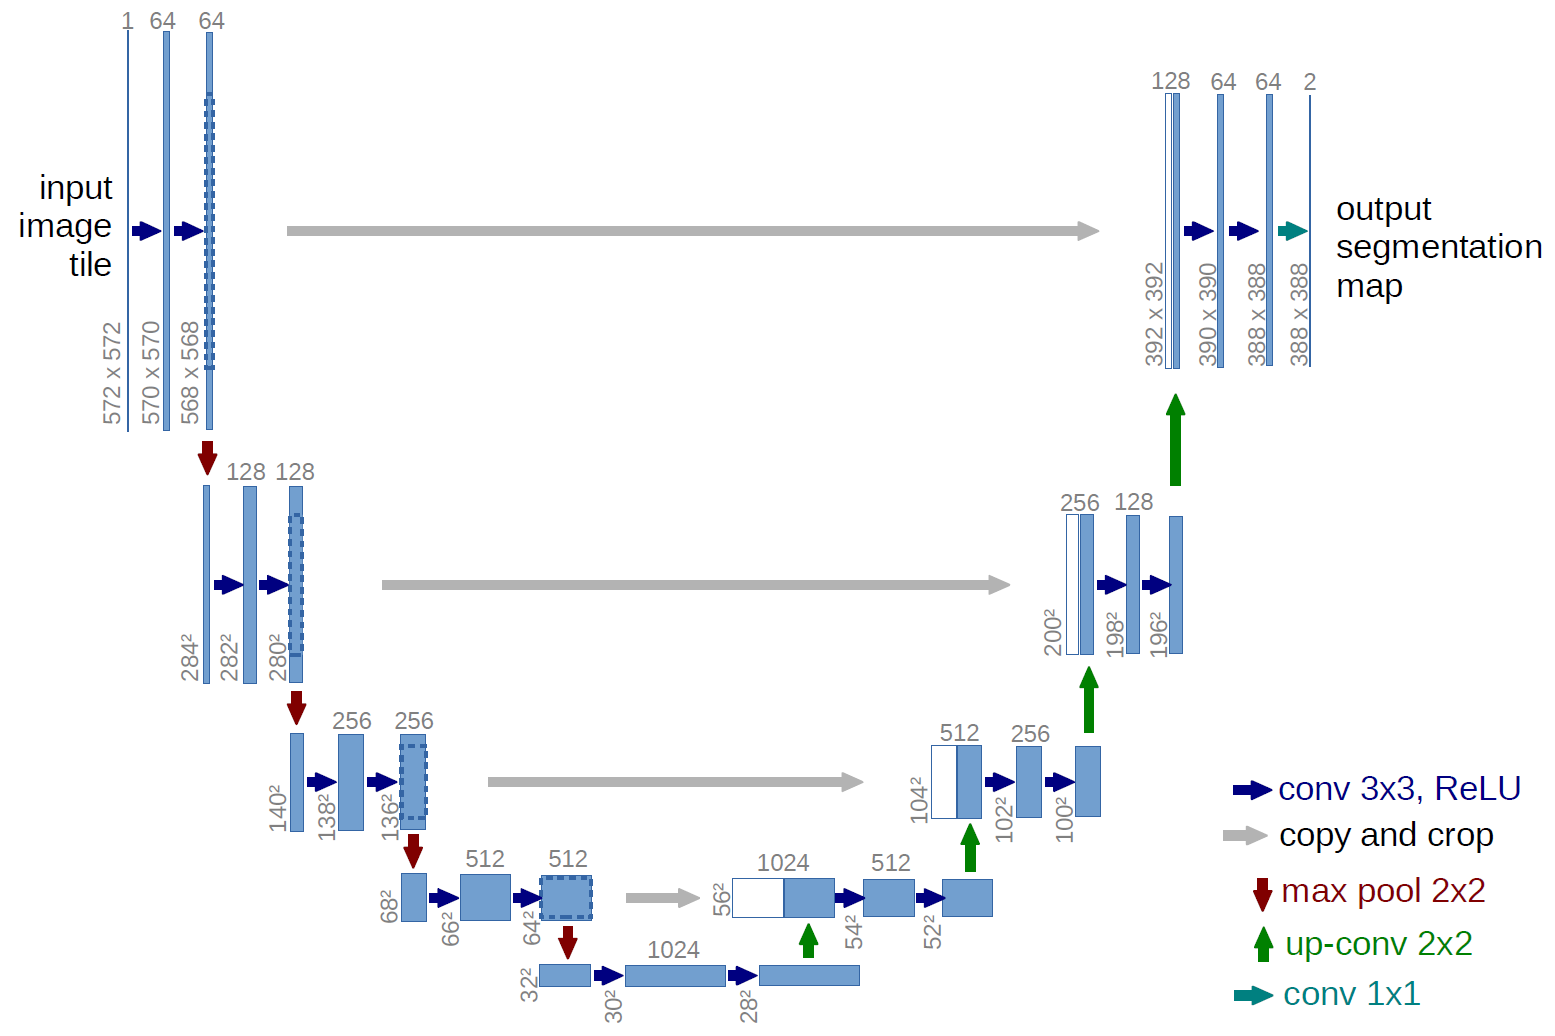


## Training and Evaluation
The notebook includes functions for training the model, visualization of training samples, and evaluation metrics computation. Early stopping is employed to prevent overfitting.

## Results
The trained model is loaded, and examples from the validation and test sets are visualized. Metrics such as accuracy, IoU, F1 score, precision, and recall are computed for assessing the model's performance.

## Import necessary libraries for image processing, deep learning, and visualization

In [15]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter


import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.utils import save_image, make_grid
from torch.utils.data import Subset, random_split

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp


In [16]:
main_directory_path = 'C:/Users/eyalra/Desktop/AITools/FloodAreaSegmentation'

import sys
import os
sys.path.append(main_directory_path)

from scripts.utils import get_processed_images_and_masks, get_augmented_images_and_masks

In [17]:
torch.cuda.empty_cache()

## Define Constants and Seed

In [18]:
IMAGE_DIR = "archive/Image/"
MASK_DIR = "archive/Mask/"

BATCH_SIZE = 8//2            # small to avoid vague faces/backgrounds
PATCH_SIZE = (256, 256)   # size of the patches

TENSOR_BOARD_BASE   = 'TB'

torch.manual_seed(42)     # Set a global random seed for reproducibility

## Define Custom Dataset Class

In [19]:
class FloodAreaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None, augmentations=None):
        self.img_labels = sorted([file for file in os.listdir(image_dir)])
        self.img_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        mask_path = os.path.join(self.mask_dir, self.img_labels[idx]).replace(".jpg", ".png")
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.augmentations:
            image, mask = self.augmentations(image, mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask.long()

## Define Image and Mask Transformations

In [20]:
image_transform = transforms.Compose([
    transforms.Resize(size=PATCH_SIZE, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=PATCH_SIZE, antialias=False)
])

# train_augmentations = transforms.Compose([
#     transforms.RandomVerticalFlip(),
# ])

In [21]:
processed_images, processed_masks = get_processed_images_and_masks()
IMAGE_DIR = os.path.dirname(processed_images[0])
MASK_DIR = os.path.dirname(processed_masks[0])

print(IMAGE_DIR, MASK_DIR)

../data/raw/images ../data/raw/masks


## Create Dataset and DataLoader Instances

In [22]:
# Define the dataset
dataset = FloodAreaDataset(IMAGE_DIR, MASK_DIR, image_transform=image_transform, mask_transform=mask_transform)

# Define the sizes for each split
dataset_size = len(dataset)
test_size = int(0.15 * dataset_size)
val_size  = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

# Use random_split to create train, test, and val datasets
train_dataset, temp_dataset = random_split(dataset, [train_size, test_size + val_size], generator=torch.Generator().manual_seed(42))
test_dataset, val_dataset = random_split(temp_dataset, [test_size, val_size], generator=torch.Generator().manual_seed(42))

# train_dataset.augmentations = train_augmentations

# Create DataLoader instances for each set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define Functions for Denormalization and Visualization

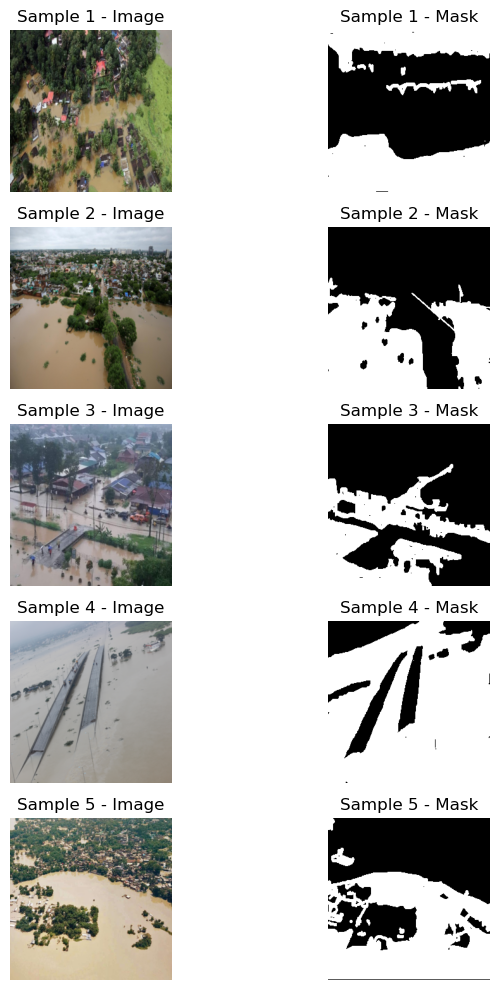

In [23]:
# Function to denormalize images
def denormalize_tensor(image, mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# Function to visualize images and masks
def visualize_samples(dataset, num_samples=5):
    # Visualize the images and masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    for i in range(num_samples):
        image, mask = dataset[np.random.randint(len(dataset))]
        
        # Display images
        axes[i, 0].imshow(denormalize_tensor(image).cpu().permute(1,2,0))
        axes[i, 0].imshow((image).cpu().permute(1,2,0))
        axes[i, 0].set_title(f'Sample {i + 1} - Image')
        axes[i, 0].axis('off')

        # Display masks
        axes[i, 1].imshow(mask.cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Sample {i + 1} - Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from the train dataset
visualize_samples(train_dataset)

## Define UNet Model

In [24]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 256x256x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)       # output: 256x256x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)      # output: 256x256x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)          # output: 128x128x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)     # output: 128x128x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)    # output: 128x128x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)          # output: 64x64x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)    # output: 64x64x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)    # output: 64x64x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)          # output: 32x32x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)    # output: 32x32x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)    # output: 32x32x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)          # output: 16x16x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)   # output: 16x16x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)  # output: 16x16x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)   # output: 32x32x1024    --> concat stage (skip layer)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)               # output: 32x32x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)                # output: 32x32x512

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)    # output: 64x64x512     --> concat stage (skip layer)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)                # output: 64x64x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)                # output: 64x64x256

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)    # output: 128x128x256   --> concat stage (skip layer)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)                # output: 128x128x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)                # output: 128x128x128

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)     # output: 256x256x128   --> concat stage (skip layer)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)                 # output: 256x256x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)                  # output: 256x256x64

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)                    # output: 256x2562x2
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out


In [25]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

## Instantiate Model

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_unet = UNet(n_class=2).to(device)
model_unet.apply(init_weights)


UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

## Define Training Constants and Initialize Early Stopping Parameters

In [27]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
LEARNING_RATE = 0.001
LR_FACTOR = 0.5
LR_PATIENCE = 2
EARLY_STOP_PATIENCE = 4
NUM_EPOCHS = 20

# Define the loss function, optimizer, and learning rate scheduler
criterion = smp.losses.DiceLoss('multiclass')
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE, verbose=False)

# Initialize early stopping parameters
early_stop_counter = 0
best_val_loss = float('inf')

c:\Users\eyalra\AppData\Local\miniconda3\envs\FloodSegProg\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [28]:
import torchinfo
torchinfo.summary(model_unet)

Layer (type:depth-idx)                   Param #
UNet                                     --
├─Conv2d: 1-1                            1,792
├─Conv2d: 1-2                            36,928
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            295,168
├─Conv2d: 1-8                            590,080
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           1,180,160
├─Conv2d: 1-11                           2,359,808
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           4,719,616
├─Conv2d: 1-14                           9,438,208
├─ConvTranspose2d: 1-15                  2,097,664
├─Conv2d: 1-16                           4,719,104
├─Conv2d: 1-17                           2,359,808
├─ConvTranspose2d: 1-18                  524,544
├─Conv2d: 1-19                     

## Plot Examples

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Function to plot examples with predicted and true masks
def plot_examples(model, dataset, num_examples=5):
    model.eval()
    
    for i in range(num_examples):
        image, mask = dataset[i]
        
        with torch.inference_mode():
            output = model(image.unsqueeze(0).to(device)).cpu()
        
        pred_mask = torch.argmax(output, dim=1)
        
        # Plot the images and masks
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        # plt.imshow(denormalize_tensor(image).permute(1,2,0))
        plt.imshow((image).permute(1,2,0))
        plt.axis("off")
        plt.title('Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('True Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Predicted Mask')
        
        plt.tight_layout()
        plt.show()

## Train the model

In [29]:
# Define the Writer
example_input = torch.randn(BATCH_SIZE, 3, 512, 512)  # Modify this based on your model's input requirements
print(example_input.shape)

# Move the example input to the same device as the model
device = next(model_unet.parameters()).device
example_input = example_input.to(device)

oTBWriter = SummaryWriter(log_dir = os.path.join(TENSOR_BOARD_BASE, 'unet_graph'))
oTBWriter.add_graph(model_unet, example_input) #<! Graph of the Model
oTBWriter.close()

torch.Size([4, 3, 512, 512])


In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stop_patience=4, oTBWriter = None):
    best_val_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    val_losses = []
    
    global_step_train = 0
    global_step_val = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Log train loss at each batch
            global_step_train += 1
            if oTBWriter is not None:
                oTBWriter.add_scalar('Train Loss', loss.item(), global_step_train)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.inference_mode():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Log validation loss at each batch
                global_step_val += 1
                if oTBWriter is not None:
                    oTBWriter.add_scalar('Validation Loss', loss.item(), global_step_val)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        #!!!
        if oTBWriter is not None:
            oTBWriter.add_scalar('Train Loss Epochs', avg_train_loss, epoch)
            oTBWriter.add_scalar('Validation Loss Epochs', avg_val_loss, epoch)
        #!!!

        # Print and check for early stopping
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Plot examples from the first epoch
        if(epoch == 1):
            plot_examples(model_unet, test_dataset, num_examples=5)

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model_basicUNET.pth')  # Save the best model
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break

    return train_losses, val_losses

# Now, call the function with your specific parameters
oTBWriter = SummaryWriter(log_dir = os.path.join(TENSOR_BOARD_BASE, 'unet'))
train_model(model_unet, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stop_patience=4, oTBWriter=oTBWriter)
oTBWriter.close()

# Load the best model after training
model_unet.load_state_dict(torch.load('best_model_basicUNET.pth'))

KeyboardInterrupt: 

## Plot Examples from Test Dataset

In [1]:
# Plot examples from the test dataloader
plot_examples(model_unet, test_dataset, num_examples=10)


NameError: name 'model_unet' is not defined

## Compute metrics for test, train and validation datasets

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score, f1_score, precision_score, recall_score

def compute_metrics(model, dataloader):
    model.eval()
    
    all_true_masks = []
    all_pred_masks = []
    
    for images, masks in tqdm(dataloader, total=len(dataloader)):
        images, masks = images.to(device), masks.to(device)
        
        with torch.inference_mode():
            outputs = model(images)
        
        # Convert probability maps to binary masks using a threshold
        pred_masks = torch.argmax(outputs, dim=1)
        
        true_masks_np = masks.cpu().detach().numpy()
        pred_masks_np = pred_masks.cpu().detach().numpy()
        
        all_true_masks.append(true_masks_np)
        all_pred_masks.append(pred_masks_np)
    
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)
    
    # Flatten masks for binary classification
    all_true_masks_flat = all_true_masks.flatten()
    all_pred_masks_flat = all_pred_masks.flatten()

    # Calculate and print metrics
    accuracy  = accuracy_score(all_true_masks_flat, all_pred_masks_flat)
    jaccard   = jaccard_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    f1        = f1_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    precision = precision_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    recall    = recall_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')

    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  IoU      : {jaccard:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")

# Compute metrics for training set
print("Metrics for Training Set:")
compute_metrics(model_unet, train_loader)

# Compute metrics for validation set
print("\nMetrics for Validation Set:")
compute_metrics(model_unet, val_loader)

# Compute metrics for test set (replace test_loader with your actual test dataloader)
print("\nMetrics for Test Set:")
compute_metrics(model_unet, test_loader)


Metrics for Training Set:


100%|██████████| 51/51 [09:08<00:00, 10.76s/it]


  Accuracy : 0.8406
  IoU      : 0.7253
  F1 Score : 0.8395
  Precision: 0.8397
  Recall   : 0.8406

Metrics for Validation Set:


100%|██████████| 11/11 [01:56<00:00, 10.63s/it]


  Accuracy : 0.8521
  IoU      : 0.7434
  F1 Score : 0.8516
  Precision: 0.8514
  Recall   : 0.8521

Metrics for Test Set:


100%|██████████| 11/11 [01:55<00:00, 10.53s/it]


  Accuracy : 0.8293
  IoU      : 0.7091
  F1 Score : 0.8285
  Precision: 0.8284
  Recall   : 0.8293


# Your Thoughts?

That's a wrap! 🎉 What are your impressions? Any suggestions or tweaks to make this model even cooler? Drop your thoughts in the comments! Whether it's about the code, visualizations, or potential improvements, I'm all ears.
